# AMEX Default Prediction

## Set up

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
pd.options.display.max_rows = 200
pd.options.display.max_info_columns = 200

## Data Import

### Parquet Data

In [4]:
# load parquet data
train_data = pd.read_parquet('dataset/train.parquet')

### Label Data

In [5]:
raw_labels = pd.read_csv('dataset/train_labels.csv')

In [6]:
# fit train_labels to the same number length as train_data
customer_target_dict = dict(zip(raw_labels["customer_ID"], raw_labels["target"]))

In [7]:
train_labels = pd.DataFrame(data=train_data["customer_ID"], columns=["customer_ID"])
train_labels["target"] = train_data["customer_ID"].map(customer_target_dict)

## Data Preprocessing

### Parquet data preprocessing

1. Set nan/-1 value to the mean of their class for each feature
1. Normalize data between 0 and 1

In [8]:
columns = train_data.columns[2:]
pbar = tqdm(range(len(columns)))

for it in pbar: 
    feature = columns[it]
    feature_data = train_data[feature]
    no_nan = feature_data.isnull().sum()
    no_neg_one = (feature_data == -1).sum()

    if no_nan > 0:
        complete_data = feature_data.loc[np.logical_not(feature_data.isnull())]
        complete_labels = train_labels.loc[complete_data.index]
        nan_data = feature_data.loc[feature_data.isnull()]
        nan_labels = train_labels.loc[nan_data.index]
    elif no_neg_one > 0:
        complete_data = feature_data.loc[np.logical_not(feature_data == -1)]
        complete_labels = train_labels.loc[complete_data.index]
        nan_data = feature_data.loc[feature_data == -1]
        nan_labels = train_labels.loc[nan_data.index]
    else:
        # normalize data
        max_value = feature_data.max()
        min_value = feature_data.min()
        train_data[feature] = (train_data[feature] - min_value) / (max_value - min_value)
        continue

    # split complete_data into 2 classes: default and not_default
    default_mask = complete_labels["target"] == 1
    default_indices = complete_labels.loc[default_mask].index
    default_data = complete_data.loc[default_indices]
    mean_default_data = np.average(default_data)

    ndefault_mask = complete_labels["target"] == 0
    ndefault_indices = complete_labels.loc[ndefault_mask].index
    ndefault_data = complete_data.loc[ndefault_indices]
    mean_ndefault_data = np.average(ndefault_data)

    # split nan_data into 2 classes: default and not_default
    default_mask = nan_labels["target"] == 1
    default_indices = nan_labels.loc[default_mask].index
    train_data.loc[default_indices, feature] = mean_default_data

    ndefault_mask = nan_labels["target"] == 0
    ndefault_indices = nan_labels.loc[ndefault_mask].index
    train_data.loc[ndefault_indices, feature] = mean_ndefault_data

    # normalize data
    max_value = train_data[feature].max()
    min_value = train_data[feature].min()
    if (abs(max_value - min_value) > 0):
        train_data[feature] = (train_data[feature] - min_value) / (max_value - min_value)
    
    pbar.set_description('iter %d, feature: %s' % (it, feature))


iter 187, feature: D_145: 100%|██████████| 188/188 [02:11<00:00,  1.43it/s]


## Dimensinality Reduction

In [9]:
from sklearn import decomposition

/Users/emmadang/opt/anaconda3/envs/amex/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
numerical_data = train_data.iloc[:,2:]

In [11]:
pca_model = decomposition.PCA(n_components=0.95)
data_r = pca_model.fit(numerical_data).transform(numerical_data)

In [12]:
pca_model.explained_variance_ratio_

array([0.19782245, 0.1190792 , 0.0822417 , 0.06204117, 0.05784866,
       0.04518067, 0.03350075, 0.03027439, 0.02624651, 0.02360146,
       0.02256212, 0.01966472, 0.0173104 , 0.01620842, 0.01497682,
       0.01455924, 0.01390444, 0.01281307, 0.01219506, 0.01079176,
       0.01073576, 0.00981414, 0.00966208, 0.00870966, 0.00671598,
       0.00612121, 0.00559603, 0.00525137, 0.00501572, 0.004867  ,
       0.00478529, 0.0045892 , 0.00427876, 0.00427128, 0.00400355,
       0.00391649, 0.00379034, 0.00366845, 0.00347657, 0.00314388,
       0.00308639, 0.00301548])

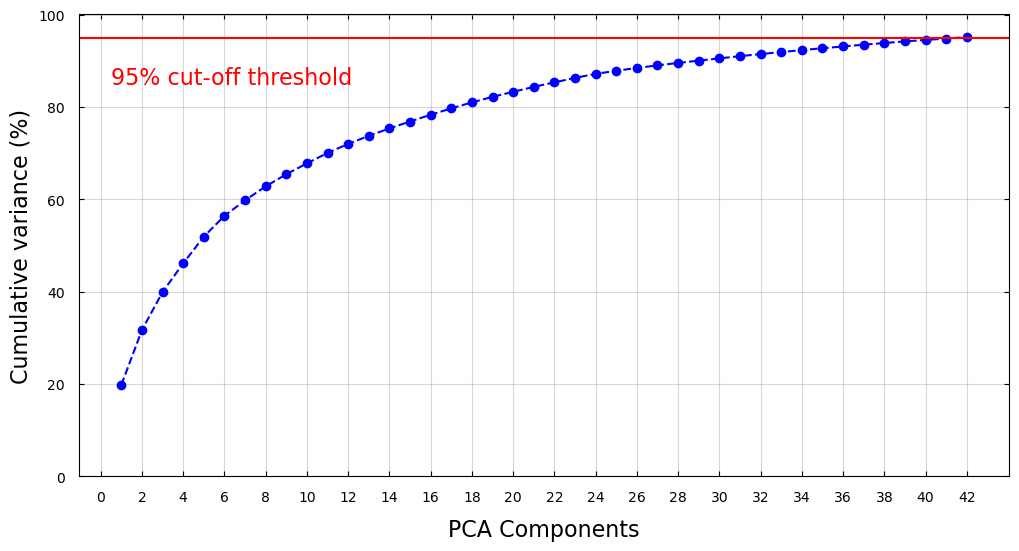

In [56]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 43, step=1)
y = np.cumsum(pca_model.explained_variance_ratio_*100)

plt.ylim(0.0, 100.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('PCA Components', fontsize=16, labelpad=10)
plt.ylabel('Cumulative variance (%)', fontsize=16)

plt.xticks(np.arange(0, 43, step=2))
plt.yticks(np.arange(0, 100.1, step=20))
plt.tick_params(axis="both",direction="in", pad=10)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

plt.axhline(y=95, color='r', linestyle='-')
plt.text(0.5, 85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='both', alpha=0.5)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
target_names = ["compliance", "default"]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
colors = ["turquoise", "darkorange"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(
        data_r[train_labels["target"]==i, 0], data_r[train_labels["target"]==i, 1], data_r[train_labels["target"]==i, 2], 
        s=9, linewidths=0.0, alpha=0.5 ,color=color, label=target_name
    )

ax.set_xlabel("PCA Component 1", labelpad=10, rotation=0)
ax.set_ylabel("PCA Component 2", labelpad=10, rotation=0)
ax.set_zlabel("PCA Component 3", labelpad=10, rotation=0)

ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(-2, 2, 1))
ax.set_zticks(np.arange(-2, 2.5, 1))

ax.legend(loc="best", shadow=False, scatterpoints=1)
ax.view_init(elev=15, azim=-60)

plt.show()

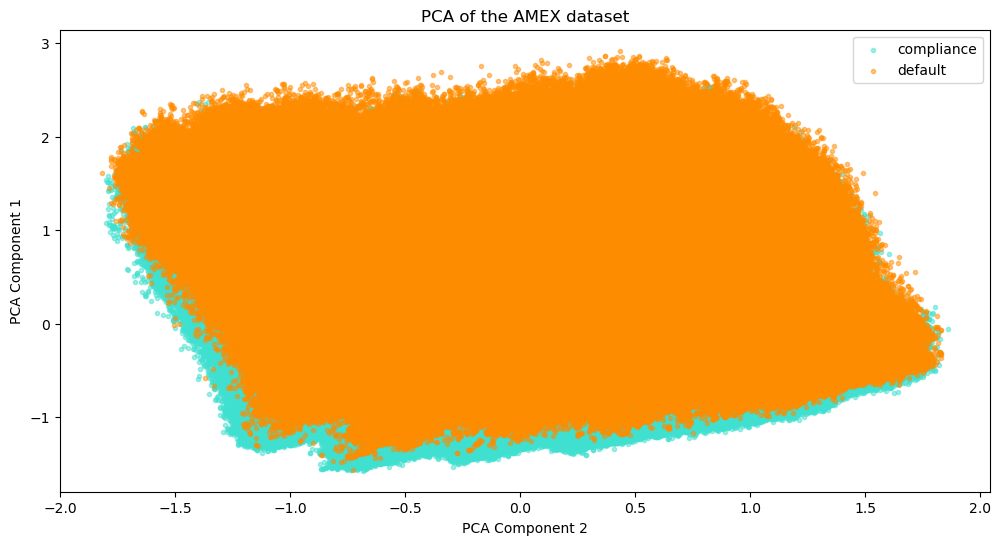

In [33]:
target_names = ["compliance", "default"]
fig = plt.figure()
colors = ["turquoise", "darkorange"]
marker_sizes = [9, 9]

for color, i, ms, target_name in zip(colors, [0, 1], marker_sizes, target_names):
    plt.scatter(
        data_r[train_labels["target"]==i, 1], data_r[train_labels["target"]==i, 0], s=ms, alpha=0.5 ,color=color, label=target_name
    )

plt.xlabel("PCA Component 2")
plt.ylabel("PCA Component 1")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of the AMEX dataset")
plt.show()

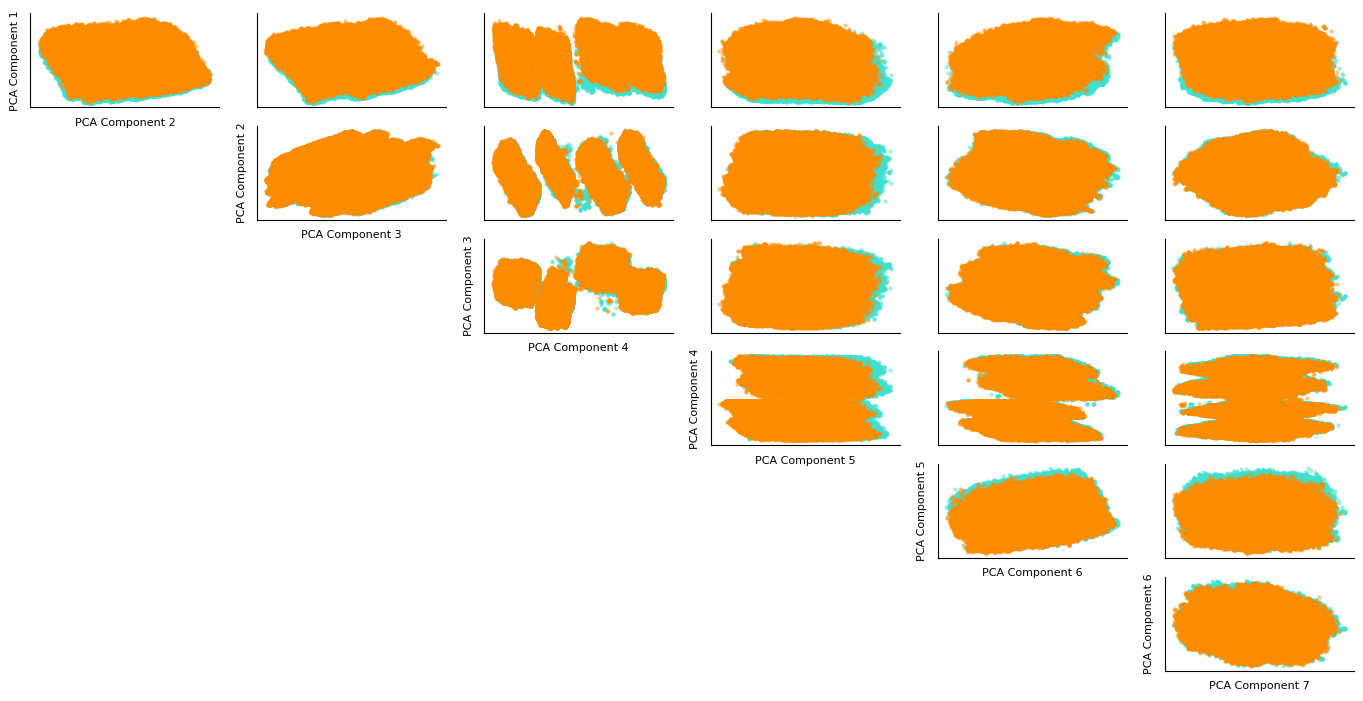

In [59]:
plt.rcParams["figure.figsize"] = (20,10)
components = 7
fig, axs = plt.subplots(components, components)
colors = ["turquoise", "darkorange"]

for r in range(components):
    for c in range(r+1, components):
        for color, i in zip(colors, [0, 1]):
            axs[r,c].scatter(
                data_r[train_labels["target"]==i, c], data_r[train_labels["target"]==i, r], 
                s=9, linewidths=0.0, alpha=0.5 ,color=color
            )
        if abs(c-r) == 1:
            axs[r,c].set_xlabel(f"PCA Component {c+1}", fontsize=8)
            axs[r,c].set_ylabel(f"PCA Component {r+1}", fontsize=8)

        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])
        axs[r,c].spines.right.set_visible(False)
        axs[r,c].spines.top.set_visible(False)

for r in range(components):
    for c in range(components):
        if r >= c:
            axs[r,c].set_visible(False)

plt.show()